# **Sentiment Analysis on Stock News**

## **Data Collection**

## *Pull News about each Stock*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from urllib.request import urlopen
from urllib.request import Request
from bs4 import BeautifulSoup
import csv
from datetime import datetime
import time as tm
import random

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

with open('news_data.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)
    # Write the header row
    csv_writer.writerow(['Stock Name','Date','Time','News Headline'])

stocks = ['TSLA','AMD','NVDA','MU','PLTR','NIO','AAPL','MARA','WBA','CLSK','F','CCL','SOFI','T','BAC','GOOGL','VALE','GOLD','INTC','AMZN','VERB','RLYB','RIVN','WISA','MSFT','COST','NKE','GL','FAST','MS','JPM']
finviz_url = 'https://finviz.com/quote.ashx?t='

for stock in stocks:
    final_url = finviz_url + stock
    request = Request(url=final_url, headers={'user-agent': 'app'}) 

    try:
        response = urlopen(request)    
        html = BeautifulSoup(response, features="lxml")
        news_table = html.find('table',id='news-table')
        news_table_row = news_table.find_all('tr')
        for news in news_table_row:
            news_headline = news.a.get_text() 
            date_scrape = news.td.text.split()
            if len(date_scrape) == 1:
                time = date_scrape[0]
                # Replace "Today" with today's date
                news_date = today_date
            else:
                date = date_scrape[0]
                time = date_scrape[1]
                # Replace "Today" with today's date
                if date.lower() == "today":
                    news_date = today_date
                else:
                    # Convert the scraped date to a datetime object
                    news_date = datetime.strptime(date, '%b-%d-%y').date()  # Extracting only the date portion
                # Check if the news date falls within the specified range

                with open('news_data.csv', 'a', newline='') as csvfile:
                    csv_writer = csv.writer(csvfile)
                    csv_writer.writerow([stock, news_date, time, news_headline])
        tm.sleep(random.randint(1,3))
    except Exception as e:
        print(e)
        print(f"Error reading the URL: {final_url}")
        continue


## *Annotate sentiments of news headlines with a pretrained model*

In [2]:
df_news = pd.read_csv('news_data.csv',encoding='ISO-8859-1')

df_news

,Stock Name,Date,Time,News Headline
0,TSLA,2024-04-11,05:45PM,Tesla (TSLA) Surpasses Market Returns: Some Fa...
1,TSLA,2024-04-10,09:42PM,Someone took apart a Tesla Cybertruck and foun...
2,TSLA,2024-04-09,07:03PM,Analyst revises Tesla stock price target after...
3,AMD,2024-04-11,10:07AM,"SoFI Technologies, Microsoft, Amazon, AMD, and..."
4,AMD,2024-04-10,04:00PM,Nasdaq Nightmares: 3 Stocks to Sell Before Rea...
...,...,...,...,...
1020,JPM,2024-04-06,07:01PM,13 Best Cheap Dividend Stocks To Buy Right Now
1021,JPM,2024-04-05,04:07PM,Weeks Best: Heres the New Magic Retirement Number
1022,JPM,2024-04-04,06:13PM,"Immigration surge is keeping job growth high, ..."
1023,JPM,2024-04-03,03:12PM,Oil Advances Near $90 as OPEC Sticks With Its ...


In [3]:
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline('sentiment-analysis', model=finbert, tokenizer=tokenizer)

df_news['Sentiment'] = df_news['News Headline'].apply(lambda x: nlp(x)[0]['label'])


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [4]:
df_news['Sentiment'].value_counts()

Sentiment
Neutral     636
Positive    285
Negative    104
Name: count, dtype: int64

## **Data Pre-processing**

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Handle emojis and specific characters
    text = re.sub(r'[:;=x][\-o\*]?[\)\(\[\]dpo\@\>\<\}3]', '', text)  # More comprehensive patterns may be needed
    # Handle hashtags and mentions
    text = re.sub(r'#[\w-]+', 'hashtag', text)  # Replace hashtags
    text = re.sub(r'@[\w-]+', 'mention', text)  # Replace mentions
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # Rejoin tokens
    return tokens

# Apply preprocessing
df_news['processed_text'] = df_news['News Headline'].apply(preprocess_text)


In [6]:
df_news['processed_text']

0       [tesla, tsla, surpasses, market, return, fact,...
1       [someone, took, apart, tesla, cybertruck, foun...
2       [analyst, revise, tesla, stock, price, target,...
3       [sofi, technology, microsoft, amazon, amd, tec...
4          [nasdaq, nightmare, stock, sell, reality, set]
                              ...                        
1020           [best, cheap, dividend, stock, buy, right]
1021    [week, best, here, new, magic, retirement, num...
1022    [immigration, surge, keeping, job, growth, hig...
1023    [oil, advance, near, opec, stick, production, ...
1024    [bluebird, bio, inc, nasdaqblue, q, earnings, ...
Name: processed_text, Length: 1025, dtype: object

## **Feature Extraction**

### Bag of Words

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # type: ignore


df_news['processed_text_str'] = df_news['processed_text'].apply(' '.join)

count_vectorizer = CountVectorizer(stop_words='english')
X_bow = count_vectorizer.fit_transform(df_news['processed_text_str'])
bow_features_df = pd.DataFrame(X_bow.toarray(), columns=count_vectorizer.get_feature_names_out())

print(bow_features_df.shape)
bow_features_df.head()

(1025, 2065)


,abcellera,ability,abroad,abstract,absurdly,accelerate,acceptance,according,account,accounting,...,yes,york,youd,youll,youngest,youre,yy,zedge,zeus,zoomed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [8]:
# TF-IDF

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(df_news['processed_text_str'])
tfidf_features_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_features_df

,abcellera,ability,abroad,abstract,absurdly,accelerate,acceptance,according,account,accounting,...,yes,york,youd,youll,youngest,youre,yy,zedge,zeus,zoomed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### BERT

In [9]:
# bert model
from transformers import BertTokenizer, BertModel
import torch

bert_model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

* Model has vocabulary of 30522,12 bert layer.

In [11]:
# tokenize with bert tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df_news['processed_text_str'] = df_news['processed_text'].apply(' '.join)


In [12]:
# function to get the embeddings

def get_bert_embeddings(text,tokenizer,model):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True,max_length=512)
    with torch.no_grad():
        model_output = model(**encoded_input)
        embeddings = model_output.last_hidden_state[:,0,:]
    return embeddings.cpu().numpy()

# get the embeddings

bert_embeddings = get_bert_embeddings(df_news['processed_text_str'].tolist(),tokenizer,bert_model)
bert_embeddings_df = pd.DataFrame(bert_embeddings, columns=[f'bert_{i}' for i in range(bert_embeddings.shape[1])])

bert_embeddings_df

,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,bert_8,bert_9,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,-0.589539,0.145855,0.432793,0.359879,-0.168816,0.327855,0.372936,0.458801,-0.571239,-0.324973,...,0.187228,0.151363,0.343408,-0.040483,0.825734,-0.178170,0.377712,-0.370487,0.053461,0.255985
1,-0.377995,0.111993,0.216055,0.191017,-0.156539,-0.127283,0.656403,0.613033,-0.209532,0.197175,...,-0.257678,-0.243143,0.176315,0.170483,0.405059,-0.432603,0.202930,-0.737332,0.279775,-0.001458
2,-0.192664,-0.359693,-0.049057,-0.046098,-0.291345,-0.201813,0.322486,0.424823,0.005324,-0.045705,...,0.036715,0.147371,0.382176,0.167866,0.291169,-0.237090,-0.388250,-0.377144,0.402817,0.366021
3,-0.511952,-0.215052,-0.062394,-0.251619,-0.029718,0.029445,0.344883,0.744136,-0.453558,-0.390120,...,-0.040117,-0.201767,0.094178,-0.041918,0.542883,0.068237,-0.284600,-0.397115,0.251353,0.060376
4,-0.508884,-0.021290,-0.028341,-0.026267,0.232414,0.001464,-0.250887,0.531122,-0.472093,-0.113845,...,0.065793,-0.154337,-0.101425,-0.090690,0.559653,0.317634,0.020860,-0.212173,0.098266,0.255136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,-0.332823,-0.261203,-0.289560,0.166216,-0.168174,-0.180898,0.029865,0.727963,0.198499,-0.178444,...,-0.109522,-0.049521,0.322299,-0.015375,0.180945,0.078438,-0.534873,-0.415949,0.073833,0.663103
1021,-0.679878,-0.143123,0.146573,-0.145544,-0.446503,-0.071481,0.606897,0.129981,-0.429722,0.020692,...,-0.079477,-0.084680,0.414296,0.028383,0.428918,-0.004798,-0.070930,-0.484609,0.114244,0.309388
1022,-0.668561,-0.132802,-0.080014,0.014939,-0.077920,0.253721,0.330263,0.424386,-0.748855,-0.153549,...,-0.343758,-0.382471,-0.131085,0.163793,1.051793,-0.183709,-0.471525,-0.227861,0.168425,0.067085
1023,-0.931263,-0.119911,-0.385121,0.135508,0.046459,0.118242,-0.143451,0.444706,-0.168884,-0.278231,...,0.252580,0.051640,-0.173893,0.078956,0.211405,-0.403284,0.006626,-0.063152,0.183799,-0.025524


* We are taking BERT embedding because Sentimental analysis requires understanding the context and subtleties of language.
* We took BERT-base model which have a embedding dimension of 768.
* When compares to other methods BERT embedding have only 768 features and they have 2052.

## **Model Selection and Training**

In [14]:
from sklearn.model_selection import train_test_split

# Assuming `df_news['sentiment']` is your target variable and is binary (0 for negative, 1 for positive sentiment)
# Convert sentiment to numeric if it's not already

df_news['sentiment_numeric'] = df_news['Sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

y = df_news['sentiment_numeric'].values

X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, y, test_size=0.2, random_state=42)


In [15]:
X_train.shape

(820, 768)

In [16]:
X_test.shape

(205, 768)

* We are taking SVM because it will be a good for high dimensional feeature.
* BERT has high dimensional features (768)
* SVMs are also robust to overfitting, especially in high-dimensional spaces, which complements the rich feature set derived from BERT.

* For a three-class classification problem using Support Vector Machine (SVM) with BERT embeddings, SVM uses  a strategy like One-vs-All (OvA) or One-vs-One (OvO).
* The multiclass support is handled according to a one-vs-one scheme.

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import joblib

# Train with BERT features
classifier = SVC(kernel='linear', C=1.0, decision_function_shape='ovr')  # OvR strategy for multi-class
classifier.fit(X_train, y_train)

# Save the model
joblib.dump(classifier, 'svm_model.pkl')

# Predict on the train set

predictions_train = classifier.predict(X_train)

# Predict on the test set
predictions_test = classifier.predict(X_test)


# Calculate accuracy

accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)

print(f'Train accuracy: {accuracy_train}')
print(f'Test accuracy: {accuracy_test}')



Train accuracy: 0.9963414634146341
Test accuracy: 0.7024390243902439


### *Interpretation of results*

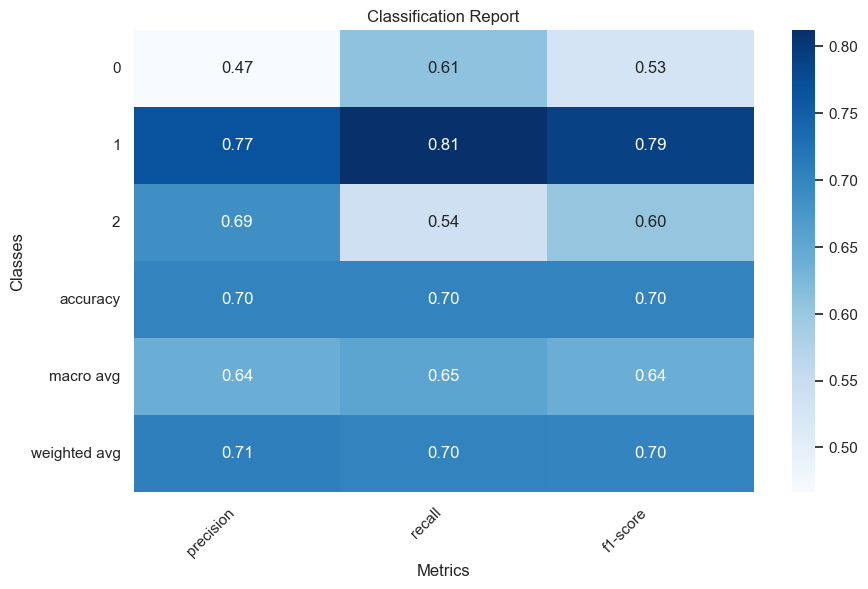

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

report_dict = classification_report(y_test, predictions_test, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Rename the index to match your specific class labels
class_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
# Replace numeric indices with actual class labels
df_report.index = [class_labels.get(i, i) for i in df_report.index]

# Configure the plot with seaborn
sns.set(style="whitegrid")

# Drop the 'support' column to only display the precision, recall, and f1-score
df_plot = df_report.drop(columns=["support"])

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_plot, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')

# This adjustment helps in case labels overlap with the heatmap cells
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()
